In [1]:
#source("https://bioconductor.org/biocLite.R")
#biocLite('Biobase')
#biocLite('GEOquery')

library(NMF)
library(matrixStats)
library(Biobase)
library(GEOquery)
library(matrixStats)



Loading required package: pkgmaker
Loading required package: registry

Attaching package: 'pkgmaker'

The following object is masked from 'package:base':

    isNamespaceLoaded

Loading required package: rngtools
Loading required package: cluster
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: windows] | Cores 3/4
matrixStats v0.51.0 (2016-10-08) successfully loaded. See ?matrixStats for help.

Attaching package: 'matrixStats'

The following objects are masked from 'package:Biobase':

    anyMissing, rowMedians

Setting options('download.file.method.GEOquery'='auto')
Setting options('GEOquery.inmemory.gpl'=FALSE)


In [23]:
VdNMF <- function(
    gseNum = 'GSE21501',         #GSE dataset to extract expression values from.  21501 = Pancreatic cancer microarrays.

    k = 14,                      #User's guess for a reasonable number of factorrs.
    kLow = k - 2,               #Lower bound for the range of factors tested by nmf.
    kHigh = k + 2,              #Upper bound for the range of factors tested by nmf.
    numRuns = 10,               #Number of NMF runs.  This can also be changed to run to convergence.
    nmfMethod = 'brunet',       #Specific NMF algorithm to use.  See NMF library for options.  

    numGenes = 500,             #TESTING VARIABLE: restricted number of genes for run time.
    topGeneCutoff = 50,        #TESTING VARIABLE: restricted number of top genes for run time.
    numSamples = 132
    )
    
    {
    #retrieve specified dataset, convert to nonnegative format, and run initial NMF to determine appropriate k value.
    gse <- getGEO(gseNum, GSEMatrix=TRUE)
    exprSetGSE <- gse[[1]]
    
    inputExprs <- exprs(exprSetGSE)
    unlogExprs <- (2^inputExprs) + 1
    nnExprs <- log2(unlogExprs)

    #TESTING VARIABLE
    subNnExprs <- nnExprs[1:numGenes,]    
    
    nmfRes <- nmf(subNnExprs, seq(kLow, kHigh, 1), nrun = numRuns, method=nmfMethod, .opt = "v")
    
    plot(nmfRes)

    #Cophenetic coefficient is an expression (0-1) of how consistently samples are assigned to the same cluster over
    #iterations of the NMF.
    
    sumNMF <- summary(nmfRes)
    kList <- seq(kLow, kHigh, 1)
    cophenetic <- sumNMF[,"cophenetic"]
    peak <- rep(0, length(kList))

    for (i in 2:(length(cophenetic) - 1)) if (cophenetic[i-1] < cophenetic[i] & cophenetic[i] > cophenetic[i+1]) {
        peak[i] <- 1
    }

    peaks <- kList[peak == 1]
    k <- rev(peaks)[1]
        
    consensusmap(nmfRes)

    print(paste("Suggested k value (number of factors):", k))
}



https://ftp.ncbi.nlm.nih.gov/geo/series/GSE21nnn/GSE21501/matrix/
OK
Found 1 file(s)
GSE21501_series_matrix.txt.gz
Using locally cached version: C:\Users\mayars1\AppData\Local\Temp\Rtmpcnr3TR/GSE21501_series_matrix.txt.gz
Using locally cached version of GPL4133 found here:
C:\Users\mayars1\AppData\Local\Temp\Rtmpcnr3TR/GPL4133.soft 
Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"not all columns named in 'colClasses' exist"

Compute NMF rank= 12  ... + measures ... OK
Compute NMF rank= 13  ... + measures ... OK
Compute NMF rank= 14  ... + measures ... OK
Compute NMF rank= 15  ... + measures ... OK
Compute NMF rank= 16  ... + measures ... OK
[1] "Suggested k value (number of factors): NA"


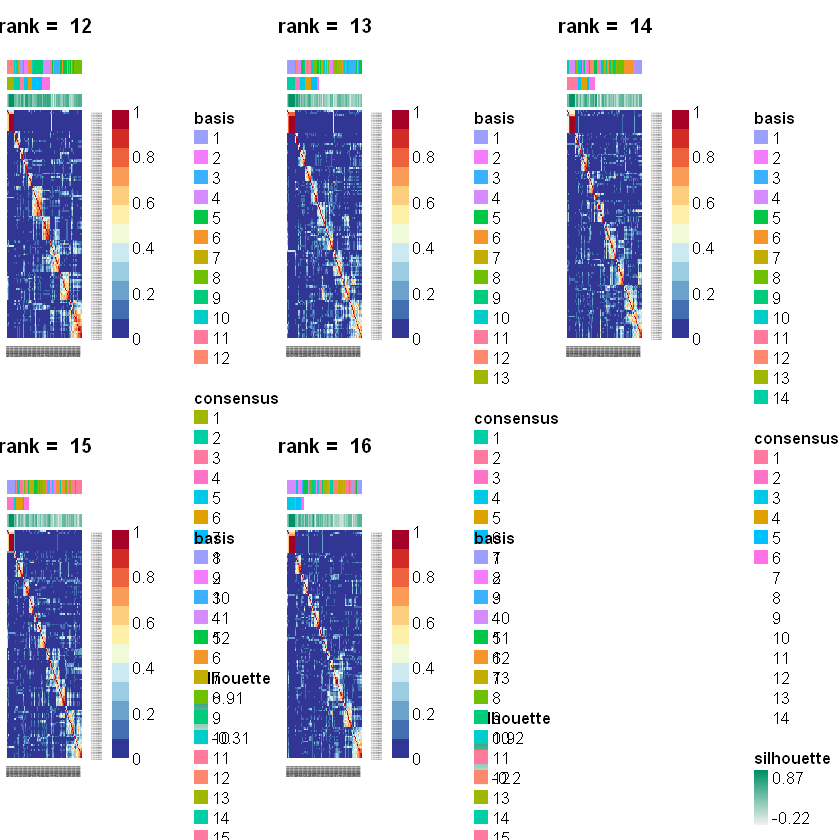

In [24]:

VdNMF()

In [28]:
VdNMFTopGenes <- function(
    #Returns top genes (default 50) differentiating factors.  Top genes are identified by their
    exprsSet,
    k = 14,                     #Number of factors for NMF.
    topGeneCutoff = 50        #Number of top genes to return.        
    )

    {
    nmfRes <- nmf(subNnExprs, k, method=nmfMethod)
    nmfLsRes <- nmf(subNnExprs, k, method="snmf/l", seed = nmfRes)
                
    #NMF factors matrix V into matrices W (weights) and H (basis).
    #In this case, S = W (sample loadings) and G = H (gene loadings).
    S <- coef(nmfLsRes)
    G <- basis(nmfLsRes)

    #Normalize both G and S to make the column means of G = 1
    for (i in 1:14){
        colMean <- mean(G[,i])
        G[,i] <- G[,i] / colMean
        S[i,] <- S[i,] * colMean
    }
    #diff_G is a matrix of differences between gene loading values (G) and the max loading value for that gene (outside of the present)
    #column.

    diffG <- G

    for (j in 1:14){
        for (i in 1:numGenes){
            diffG[i, j] <- diffG[i,j] - max(G[i, -j]) 
        }
    }

    #G3 is the difference absolute values

    absValG <- abs(diffG)

    topGeneCutoff = 50
    numSamples = 132

    topGenes <- mat.or.vec(topGeneCutoff,k)

    for(i in 1:14){
        topGenes[,i]<-rownames(head(absValG[order(absValG[,i], decreasing=TRUE),0],topGeneCutoff))  
    }
        
    distanceMatrix <- dist(t(topGenes))
    hierClust <- hclust(distanceMatrix, method="complete")
    topGenes <- topGenes[,hierClust$order]
    
    distanceMatrix <- dist(topGenes)
    hierClust <- hclust(distanceMatrix, method="complete")
    topGenes <- topGenes[hierClust$order,]
    
    return(topGenes)         
        
}

In [ ]:
VdNMFTopGenes(exprsSet = subNnExprs)